# Deep Learning in the Weeds

## Introduction

<img src='./img/ex1.png',width=300>

I am using [the Plant Seedlings Dataset](https://vision.eng.au.dk/plant-seedlings-dataset/) from Aarhus University's Computer Vision and Biosystems Signal Processing Group. They planted 12 different species of seedlings at the Flakkebjerg Research station, under controlled conditions, and regularly monitored the seedlings to capture images of them at various stages of their growth. The result is a dataset of nearly 4,750 images consisting of 12 species of seedlings.

The goal of this project is to build a CNN model to classify the 12 species of seedlings.

In [8]:
## Import python libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import time 
import cv2
import os

from PIL import Image
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use('seaborn')
%matplotlib inline

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras.utils import np_utils

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## my functions
from pre_processing import *
from models import *
from plots import *
from compiler_evaluate import *
from segments import *

import warnings
warnings.filterwarnings('ignore')

## 1. Load Files

Image Files are stored in sub-directories named for each seedling species.

In [9]:
## load files
path="../input/image_data"

data = load_files(path)

files = np.array(data['filenames'])
#targets = np_utils.to_categorical(np.array(data['target']), 12)

## Make data frame with each file & label
df = pd.DataFrame({'label': data.target, 'file': data.filenames})

In [16]:
data.filenames[:10]

array(['../input/image_data/Shepherds Purse/f900b7684.png',
       '../input/image_data/Fat Hen/9a8531ba0.png',
       '../input/image_data/Common Chickweed/aac309dc5.png',
       '../input/image_data/Small-flowered Cranesbill/801c3e668.png',
       '../input/image_data/Cleavers/be41914d8.png',
       '../input/image_data/Maize/5a7d10c3d.png',
       '../input/image_data/Common Chickweed/bfb59c16f.png',
       '../input/image_data/Common Chickweed/a9e03b3a1.png',
       '../input/image_data/Scentless Mayweed/fd0ca2322.png',
       '../input/image_data/Sugar beet/cfb3565b9.png'], dtype='<U59')

In [15]:
data.target[:10]

array([ 9,  5,  3, 10,  2,  7,  3,  3,  8, 11])

In [11]:
df.head(10)

,file,label
0,../input/image_data/Shepherds Purse/f900b7684.png,9
1,../input/image_data/Fat Hen/9a8531ba0.png,5
2,../input/image_data/Common Chickweed/aac309dc5...,3
3,../input/image_data/Small-flowered Cranesbill/...,10
4,../input/image_data/Cleavers/be41914d8.png,2
5,../input/image_data/Maize/5a7d10c3d.png,7
6,../input/image_data/Common Chickweed/bfb59c16f...,3
7,../input/image_data/Common Chickweed/a9e03b3a1...,3
8,../input/image_data/Scentless Mayweed/fd0ca232...,8
9,../input/image_data/Sugar beet/cfb3565b9.png,11


## 2. Data Exploration

In [18]:
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 
              'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 
              'Small-flowered Cranesbill', 'Sugar beet']
abbreviation = [name[:2] for name in categories]

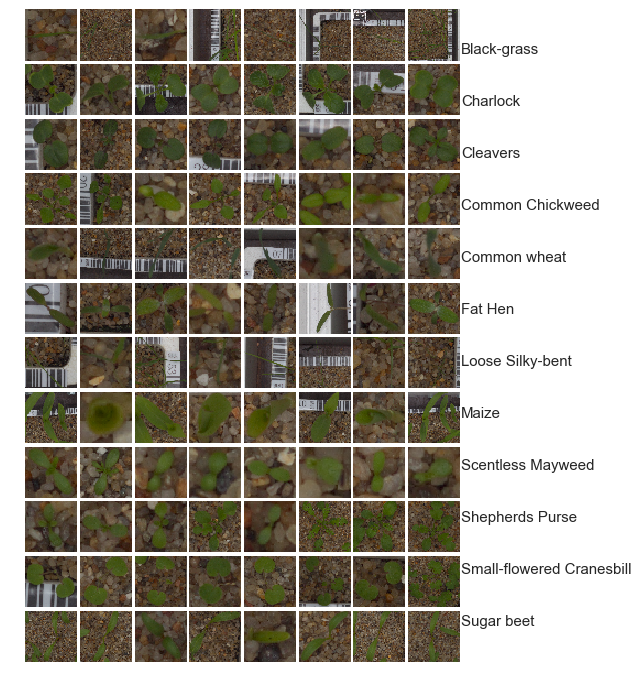

In [19]:
def read_img(filepath, size):
    """
    Load images from files into array (using keras.image)
    """
    img = image.load_img(filepath, target_size=size)
    img = image.img_to_array(img)
    return img

## Display Representative thumbnails of each species
fig = plt.figure(1, figsize=(12,12))
grid = ImageGrid(fig, 111, nrows_ncols=(12,8), axes_pad=0.05)
i = 0
for category_id, category in enumerate(categories):
    for filepath in df[df['label'] == category_id]['file'].values[:8]:
        ax = grid[i]
        img = read_img('../input/'+filepath, (47, 47))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % 8 == 2:
            ax.text(300, 40 - i*0.3, filepath.split('/')[3],fontsize=15)
        i += 1
plt.show();

In [20]:
## Print number of images for each species
n=[]
for i in range(12):
    n.append(df[df.label==i].shape[0])
number = pd.DataFrame({'label': categories, 'n': n})

print('=========Number of images for each category==========')
number.sort_values('n',ascending=False)

=========Number of images for each category==========


,label,n
6,Loose Silky-bent,654
3,Common Chickweed,611
8,Scentless Mayweed,516
10,Small-flowered Cranesbill,496
5,Fat Hen,475
1,Charlock,390
11,Sugar beet,385
2,Cleavers,287
0,Black-grass,263
9,Shepherds Purse,231


As you can see above, the classes are slightly imbalanced. It might be helpful to downsample or upsample to have a more balanced dataset. For my first pass, I will use the full dataset.

In [21]:
## Examine the distributions of image dimensions 
s=[]
for i in df.file.values:
    m = image.img_to_array(image.load_img(i))
    s.append(m.shape)
    
dimension = pd.DataFrame({'label': data.target, 'file': data.filenames, 'dim':s})

In [23]:
dimension.head()

,dim,file,label
0,"(98, 98, 3)",../input/image_data/Shepherds Purse/f900b7684.png,9
1,"(178, 178, 3)",../input/image_data/Fat Hen/9a8531ba0.png,5
2,"(410, 410, 3)",../input/image_data/Common Chickweed/aac309dc5...,3
3,"(209, 209, 3)",../input/image_data/Small-flowered Cranesbill/...,10
4,"(190, 190, 3)",../input/image_data/Cleavers/be41914d8.png,2


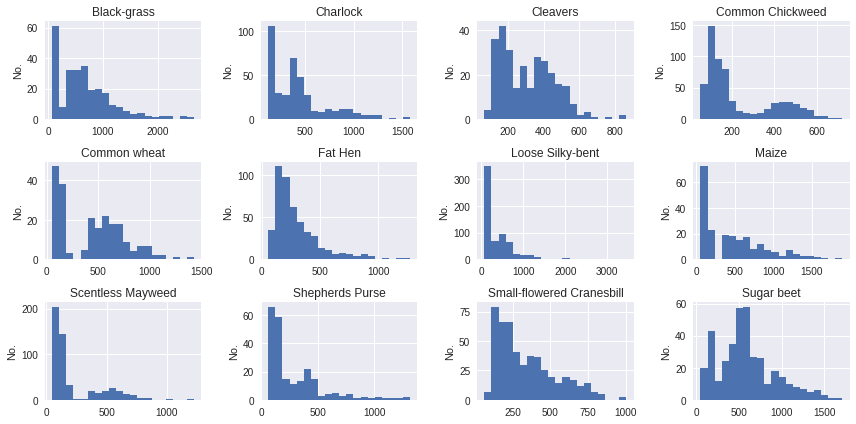

In [34]:
def plot_hist_dim(dimension, title):
    """
    Make a histogram of image sizes
    """
    dimension.dim.apply(lambda x: x[0]).hist(bins=20)
    plt.title(title)
    plt.ylabel('No.')
    
plt.figure(1, figsize=(12,6))
for i in range(12):
    plt.subplot(3,4,i+1)
    plot_hist_dim(dimension[dimension['label']==i],categories[i])
plt.tight_layout()
plt.show()

There are pretty wide distributions of image sizes, spanning about 47 to more than 2000. Note that the images were taken at various stages of seedlings growth. Therefore, the earliest stages (when the seedlings were the smallest) would have smaller cropped images containing seedlings.

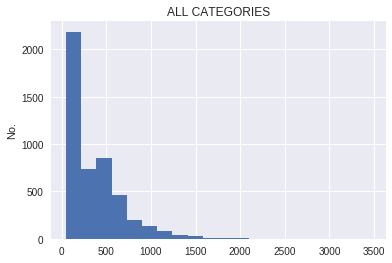

In [35]:
plt.figure(1, figsize=(6,4))
plot_hist_dim(dimension,'ALL CATEGORIES')

## 3. Preprocessing & Sampling

To preprocess the input images, I resize them to a uniform scale. I also need to decide whether to use all three color chanels (RGB) in my model or whether to convert them all to grey scale. Furthermore, I need to decide whether to upsample some of the classes that are less numerous, to downsample some of the classes that are more numerous, or to leave the samples unchanged.  Overall, I have the following pre-processing decisions:

(1) Image size (small, medium, large)  
(2) RGB vs Grey  
(3) All data, downsampling or upsampling

So, speaking of upsampling, Keras has ImageDataGenerator, which performs Image Augmentation to make a new set of representative images, based on slight modification to existing input images (i.e., by rotating, shifting, or flipping)

Examples of augmented images

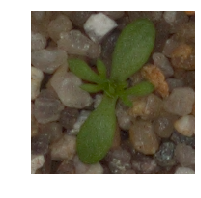

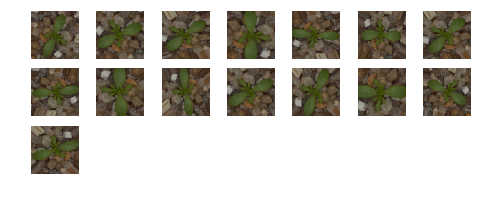

In [37]:
img_path = df.file[10]
img = imread(img_path)
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.axis('off')
plt.show()

img = np.expand_dims(img.astype('float32')/255, axis=0)
datagen, _ = image_generator(img, rotation=90, h_flip=True, v_flip=True,
                            zoom=0.2,shear=0.1)
image_generator_plot(datagen,img)

### preprocessing

(a) Convert images to tensors with a particular size and RGB/Grey.   
(b) Normalize tensors to 0 - 1 scale  
(c) Split data into train(80%) / validation(10%) / test(10%) sample  

In [39]:
## Convert to tensors with specific size & grey
tensors, y = convert_to_tensors(df, size = 49, grey = False)

## train / val / test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_val_test(tensors, y)

100%|██████████| 4750/4750 [00:51<00:00, 93.01it/s]


## 4. Model Architectures & Training

I used three different models:

- **Model0** : three CNN layers with Maxpooling layers  
- **Model1** : six CNN layers with Maxpooling layers + several fully connected layers  
- **Model2** : six CNN layers with Maxpooling layers + several fully connected layers + Batch Normalization  

In [38]:
def run_model(model, 
              X_train, y_train, 
              X_valid, y_valid, 
              X_test, y_test,
              optimizer = Adam(), 
              batch_size = 20, epochs = 100, aug = False, 
              batch_norm=False, verbose = 0, reduce = False):
    
    start = time.clock()
    ## (1) choose a model
    model = model(X_train)
    checkfile = 'weights.hdf5'
    ## (2) configure your optimizer, and train the model
    model_info, model = compiler(model, X_train, y_train,
                                 X_valid, y_valid, 
                                 optimizer = optimizer,
                                 epochs = epochs,
                                 batch_size = batch_size,
                                 checkfile = checkfile,
                                 aug = aug, reduce = reduce,
                                 verbose = verbose)
    ## (3) evaluate the model with test set.
    test_list, pred, f1, acc = evaluate(model, X_test, y_test, checkfile = checkfile)
    end = time.clock()
    
    ## (4) return model info, test & prediction, and result F1 & Accuracy score
    return model_info, test_list, pred, f1, acc

### Train Models & Evaluate

The following code trains all of my models and saves the relevant information in a list of dictionaries. I am iterating through each model with image augmentation turned on or off to explicitly determine how image augmentation helps. 

### (1) Train Model0 with different optimizers

In [40]:
## Model Hyper-parameters
aug_choice = [False]
model_choice = [model0, model0]
optimizer_choice = [SGD(),Adam()]
reduce_choice = [False, False]
save = []

for j in aug_choice:
    for i,k in enumerate(model_choice):
        ## run_model
        model_info, test, pred, f1, acc = run_model(model = k, X_train = X_train, 
                                                    y_train = y_train,
                                                    X_valid = X_valid, 
                                                    y_valid = y_valid, 
                                                    X_test = X_test, 
                                                    y_test = y_test, 
                                                    verbose = 1,
                                                    epochs = 150, 
                                                    batch_size = 20,
                                                    reduce = reduce_choice[i],
                                                    optimizer = optimizer_choice[i],
                                                    aug = j)

        print(j, str(i), f1, acc)
        save.append({'aug' : j,
                     'model_name' : str(k),
                      'model_info': model_info,
                     'test' : test,
                     'pred' : pred,
                     'f1': f1,
                     'acc': acc})

Train on 3800 samples, validate on 475 samples
Epoch 1/150
3800/3800 [==============================] - 3s 663us/step - loss: 2.4615 - acc: 0.1197 - val_loss: 2.4429 - val_acc: 0.1284
Epoch 2/150
3800/3800 [==============================] - 1s 306us/step - loss: 2.4312 - acc: 0.1355 - val_loss: 2.4232 - val_acc: 0.1705
Epoch 3/150
3800/3800 [==============================] - 1s 310us/step - loss: 2.4194 - acc: 0.1437 - val_loss: 2.4172 - val_acc: 0.1389
Epoch 4/150
3800/3800 [==============================] - 1s 307us/step - loss: 2.4157 - acc: 0.1376 - val_loss: 2.4148 - val_acc: 0.1389
Epoch 5/150
3800/3800 [==============================] - 1s 310us/step - loss: 2.4141 - acc: 0.1382 - val_loss: 2.4131 - val_acc: 0.1389
Epoch 6/150
3800/3800 [==============================] - 1s 313us/step - loss: 2.4127 - acc: 0.1376 - val_loss: 2.4119 - val_acc: 0.1389
Epoch 7/150
3800/3800 [==============================] - 1s 309us/step - loss: 2.4113 - acc: 0.1439 - val_loss: 2.4107 - val_acc: 0

3800/3800 [==============================] - 1s 309us/step - loss: 1.5040 - acc: 0.4687 - val_loss: 1.5191 - val_acc: 0.4968
Epoch 61/150
3800/3800 [==============================] - 1s 312us/step - loss: 1.5038 - acc: 0.4776 - val_loss: 1.5223 - val_acc: 0.4800
Epoch 62/150
3800/3800 [==============================] - 1s 307us/step - loss: 1.4944 - acc: 0.4726 - val_loss: 1.4911 - val_acc: 0.4779
Epoch 63/150
3800/3800 [==============================] - 1s 307us/step - loss: 1.4802 - acc: 0.4695 - val_loss: 1.5028 - val_acc: 0.4737
Epoch 64/150
3800/3800 [==============================] - 1s 308us/step - loss: 1.4711 - acc: 0.4879 - val_loss: 1.5155 - val_acc: 0.5263
Epoch 65/150
3800/3800 [==============================] - 1s 310us/step - loss: 1.4533 - acc: 0.4916 - val_loss: 1.4770 - val_acc: 0.4863
Epoch 66/150
3800/3800 [==============================] - 1s 309us/step - loss: 1.4527 - acc: 0.4947 - val_loss: 1.4948 - val_acc: 0.4884
Epoch 67/150
3800/3800 [=======================

3800/3800 [==============================] - 1s 355us/step - loss: 1.2151 - acc: 0.5926 - val_loss: 1.2054 - val_acc: 0.5916
Epoch 28/150
3800/3800 [==============================] - 1s 353us/step - loss: 1.1870 - acc: 0.6013 - val_loss: 1.1951 - val_acc: 0.6253
Epoch 29/150
3800/3800 [==============================] - 1s 354us/step - loss: 1.1791 - acc: 0.6079 - val_loss: 1.1900 - val_acc: 0.5937
Epoch 30/150
3800/3800 [==============================] - 1s 354us/step - loss: 1.1688 - acc: 0.6089 - val_loss: 1.1670 - val_acc: 0.5979
Epoch 31/150
3800/3800 [==============================] - 1s 364us/step - loss: 1.1633 - acc: 0.6095 - val_loss: 1.1847 - val_acc: 0.5937
Epoch 32/150
3800/3800 [==============================] - 1s 365us/step - loss: 1.1488 - acc: 0.6192 - val_loss: 1.2386 - val_acc: 0.5558
Epoch 33/150
3800/3800 [==============================] - 1s 355us/step - loss: 1.1409 - acc: 0.6192 - val_loss: 1.1382 - val_acc: 0.6105
Epoch 34/150
3800/3800 [=======================

3800/3800 [==============================] - 1s 355us/step - loss: 0.5236 - acc: 0.8255 - val_loss: 0.6411 - val_acc: 0.7558
Epoch 146/150
3800/3800 [==============================] - 1s 353us/step - loss: 0.5156 - acc: 0.8287 - val_loss: 0.6043 - val_acc: 0.7979
Epoch 147/150
3800/3800 [==============================] - 1s 357us/step - loss: 0.5093 - acc: 0.8318 - val_loss: 0.5600 - val_acc: 0.7916
Epoch 148/150
3800/3800 [==============================] - 1s 356us/step - loss: 0.5044 - acc: 0.8337 - val_loss: 0.5806 - val_acc: 0.7916
Epoch 149/150
3800/3800 [==============================] - 1s 358us/step - loss: 0.5026 - acc: 0.8326 - val_loss: 0.6263 - val_acc: 0.7832
Epoch 150/150
3800/3800 [==============================] - 1s 357us/step - loss: 0.4994 - acc: 0.8350 - val_loss: 0.5800 - val_acc: 0.7937
False 1 0.7842175620715351 0.8147368421052632


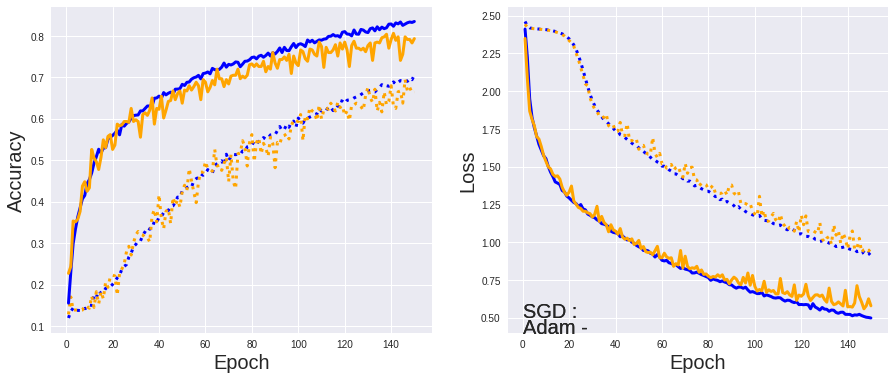

In [42]:
## plot learning curves with SGD and Adam
plot_results_1([save[0]["model_info"], 
                save[1]["model_info"]], ['SGD','Adam'])

The blue lines are training results and the orange lines are validation results. The dotted lines are showing accuracy and loss for model0 with SGD while the solid lines correspond to Adam.

### (2) Train Model0, Model1, Model2

In [43]:
## Model Hyper-parameters
aug_choice = [True]
model_choice = [model0, model1, model2]
optimizer_choice = [Adam(), RMSprop(), Adam(0.001)]
reduce_choice = [False, False, True]
save1 = []

for j in aug_choice:
    for i,k in enumerate(model_choice):
        ## run_model
        model_info, test, pred, f1, acc = run_model(model = k, X_train = X_train, 
                                                    y_train = y_train,
                                                    X_valid = X_valid, 
                                                    y_valid = y_valid, 
                                                    verbose = 1,
                                                    X_test = X_test, 
                                                    y_test = y_test, 
                                                    epochs = 200, 
                                                    batch_size = 20,
                                                    reduce = reduce_choice[i],
                                                    optimizer = optimizer_choice[i],
                                                    aug = j)

        print(j, str(i), f1, acc)
        save1.append({'aug' : j,
                     'model_name' : str(k),
                      'model_info': model_info,
                     'test' : test,
                     'pred' : pred,
                     'f1': f1,
                     'acc': acc})

Train on 3800 samples, validate on 475 samples
Epoch 1/200
3800/3800 [==============================] - 2s 466us/step - loss: 2.4201 - acc: 0.1492 - val_loss: 2.3761 - val_acc: 0.1495
Epoch 2/200
3800/3800 [==============================] - 1s 356us/step - loss: 2.2496 - acc: 0.2163 - val_loss: 2.0735 - val_acc: 0.2611
Epoch 3/200
3800/3800 [==============================] - 1s 356us/step - loss: 1.9526 - acc: 0.3047 - val_loss: 1.8216 - val_acc: 0.3453
Epoch 4/200
3800/3800 [==============================] - 1s 356us/step - loss: 1.7930 - acc: 0.3458 - val_loss: 1.7325 - val_acc: 0.3495
Epoch 5/200
3800/3800 [==============================] - 1s 357us/step - loss: 1.6963 - acc: 0.3800 - val_loss: 1.7494 - val_acc: 0.3937
Epoch 6/200
3800/3800 [==============================] - 1s 358us/step - loss: 1.6275 - acc: 0.4187 - val_loss: 1.6192 - val_acc: 0.3916
Epoch 7/200
3800/3800 [==============================] - 1s 354us/step - loss: 1.5646 - acc: 0.4453 - val_loss: 1.5523 - val_acc: 0

3800/3800 [==============================] - 1s 366us/step - loss: 0.8222 - acc: 0.7345 - val_loss: 0.8613 - val_acc: 0.7179
Epoch 61/200
3800/3800 [==============================] - 1s 367us/step - loss: 0.8364 - acc: 0.7203 - val_loss: 0.8429 - val_acc: 0.7074
Epoch 62/200
3800/3800 [==============================] - 1s 370us/step - loss: 0.8079 - acc: 0.7418 - val_loss: 0.8375 - val_acc: 0.7032
Epoch 63/200
3800/3800 [==============================] - 1s 366us/step - loss: 0.8093 - acc: 0.7413 - val_loss: 0.8451 - val_acc: 0.6842
Epoch 64/200
3800/3800 [==============================] - 1s 368us/step - loss: 0.8011 - acc: 0.7384 - val_loss: 0.7975 - val_acc: 0.7347
Epoch 65/200
3800/3800 [==============================] - 1s 367us/step - loss: 0.7822 - acc: 0.7442 - val_loss: 0.7996 - val_acc: 0.7158
Epoch 66/200
3800/3800 [==============================] - 1s 367us/step - loss: 0.7794 - acc: 0.7463 - val_loss: 0.8636 - val_acc: 0.7032
Epoch 67/200
3800/3800 [=======================

3800/3800 [==============================] - 2s 636us/step - loss: 0.3992 - acc: 0.8592 - val_loss: 0.4391 - val_acc: 0.8358
Epoch 20/200
3800/3800 [==============================] - 2s 634us/step - loss: 0.3816 - acc: 0.8605 - val_loss: 0.3688 - val_acc: 0.8758
Epoch 21/200
3800/3800 [==============================] - 2s 631us/step - loss: 0.3620 - acc: 0.8661 - val_loss: 0.3557 - val_acc: 0.8632
Epoch 22/200
3800/3800 [==============================] - 2s 633us/step - loss: 0.3399 - acc: 0.8787 - val_loss: 0.4058 - val_acc: 0.8589
Epoch 23/200
3800/3800 [==============================] - 2s 637us/step - loss: 0.3163 - acc: 0.8858 - val_loss: 0.6578 - val_acc: 0.8147
Epoch 24/200
3800/3800 [==============================] - 2s 639us/step - loss: 0.3510 - acc: 0.8766 - val_loss: 0.3073 - val_acc: 0.8821
Epoch 25/200
3800/3800 [==============================] - 2s 635us/step - loss: 0.3119 - acc: 0.8855 - val_loss: 0.5545 - val_acc: 0.8211
Epoch 26/200
3800/3800 [=======================

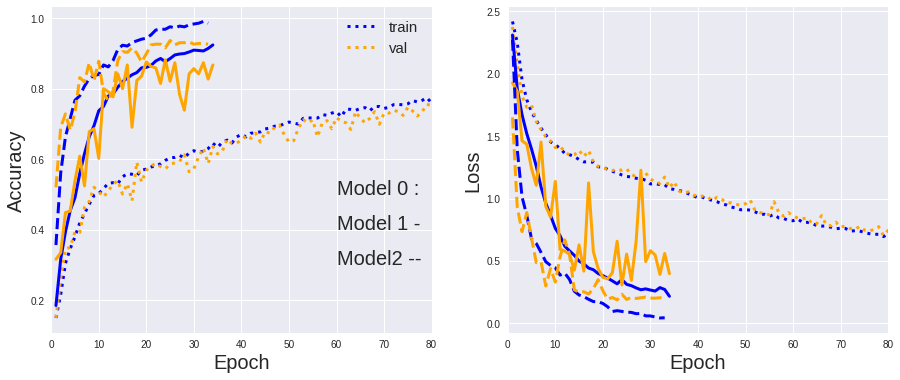

In [58]:
## plot learning curves with different models
plot_results_1([save1[0]["model_info"], 
                save1[1]["model_info"],
                save1[2]["model_info"]], 
               ['Model 0','Model 1', 'Model2'])

Model0 performs the worst with a learning curve that is very shallow, as I expected since Model0 is very simple. Model1 performs better and much faster than Model0. But, the validation curve for Model1 is very noisy, which indicates that I might need to find better hyper-parameters. Model2 is the best, overall. It converges faster to higher accuracy and lower loss than the other models, and the validation curve appears much more stable. The increased stability could be in part because I used keras.callbacks.ReduceLROnPlateau, which is a method that decreases the learning rate when the metric does not improved for several epochs.

In [59]:
print('=================Model 0 ======================')
print('F1 : {}'.format(round(save1[0]['f1'],2)))
print('Accuracy : {}'.format(round(save1[0]['acc'],2)))

print('=================Model 1 ======================')
print('F1 : {}'.format(round(save1[1]['f1'],2)))
print('Accuracy : {}'.format(round(save1[1]['acc'],2)))

print('=================Model 2 ======================')
print('F1 : {}'.format(round(save1[2]['f1'],2)))
print('Accuracy : {}'.format(round(save1[2]['acc'],2)))

=================Model 0 ======================
F1 : 0.8
Accuracy : 0.83
=================Model 1 ======================
F1 : 0.85
Accuracy : 0.88
=================Model 2 ======================
F1 : 0.91
Accuracy : 0.92


<Figure size 720x360 with 0 Axes>

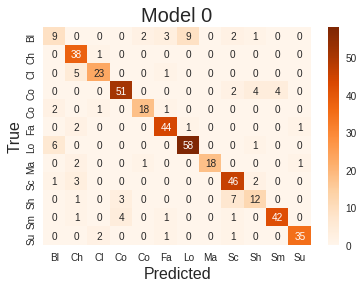

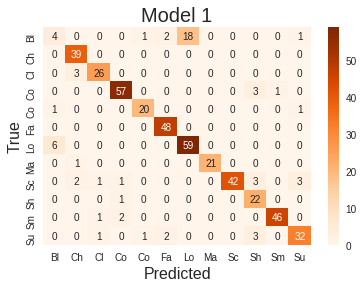

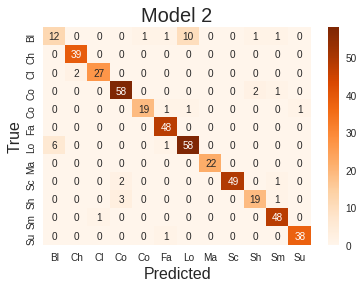

In [72]:
plt.figure(figsize=(10,5))
name=['Model 0', 'Model 1','Model 2']
for i in range(3):
    fig, ax = plt.subplots(1)
    confusion = confusion_matrix(save1[i]['test'], save1[i]['pred'])
    ax = sns.heatmap(confusion, ax = ax, cmap=plt.cm.Oranges, annot=True)
    ax.set_xticklabels(abbreviation)
    ax.set_yticklabels(abbreviation)
    plt.title(name[i], size=20)
    plt.ylabel('True', size=16)
    plt.xlabel('Predicted', size=16)
    plt.show();

In [81]:
print(classification_report(save1[2]['test'], save1[2]['pred'], target_names=abbreviation))

              precision    recall  f1-score   support

          Bl       0.67      0.46      0.55        26
          Ch       0.95      1.00      0.97        39
          Cl       0.96      0.93      0.95        29
          Co       0.92      0.95      0.94        61
          Co       0.95      0.86      0.90        22
          Fa       0.92      1.00      0.96        48
          Lo       0.84      0.89      0.87        65
          Ma       1.00      1.00      1.00        22
          Sc       1.00      0.94      0.97        52
          Sh       0.86      0.83      0.84        23
          Sm       0.92      0.98      0.95        49
          Su       0.97      0.97      0.97        39

   micro avg       0.92      0.92      0.92       475
   macro avg       0.91      0.90      0.91       475
weighted avg       0.92      0.92      0.92       475



Note that Black Grass (BL) performs far worse than all the other classes. The Black Grass seedlings look very similar to Loose Silky-bent (Lo), but in the case of Lo the number of images is much higher (2.5 times greater).

## Downsampling or Upsampling?

As I mentioned earlier, we can apply image augmentation to upsample the classes that are less represented in the input dataset, or downsample the classes with more input images by excluding some of their images. I found downsampling to be a poorer choice, because it resulted in overall degraded model performance for many classes. 

Below I perform upsampling for a model.

In [73]:
tensors, y = convert_to_tensors(df, size = 49, grey = False)
tensors, y = sampling(df, tensors, y, sampling = 2, number = number)
X_train, y_train, X_valid, y_valid, X_test, y_test = train_val_test(tensors, y)

  0%|          | 0/12 [00:00<?, ?it/s]

start


100%|██████████| 12/12 [00:36<00:00,  3.02s/it]


In [75]:
model_info_up, test_up, pred_up, f1_up, acc_up  = run_model(model = model2, 
                                                            X_train = X_train, 
                                                    y_train = y_train,
                                                    X_valid = X_valid, 
                                                    y_valid = y_valid, 
                                                    verbose = 1,
                                                    X_test = X_test, 
                                                    y_test = y_test, 
                                                    epochs = 200, 
                                                    batch_size = 15,
                                                    reduce = reduce_choice[2],
                                                    optimizer = Adam(0.003),
                                                    aug = False)

Train on 6720 samples, validate on 840 samples
Epoch 1/200
6720/6720 [==============================] - 16s 2ms/step - loss: 2.1798 - acc: 0.3199 - val_loss: 1.8701 - val_acc: 0.3869
Epoch 2/200
6720/6720 [==============================] - 13s 2ms/step - loss: 1.4492 - acc: 0.4988 - val_loss: 1.6232 - val_acc: 0.5143
Epoch 3/200
6720/6720 [==============================] - 13s 2ms/step - loss: 1.1699 - acc: 0.5918 - val_loss: 1.4914 - val_acc: 0.5571
Epoch 4/200
6720/6720 [==============================] - 13s 2ms/step - loss: 1.0062 - acc: 0.6542 - val_loss: 1.1560 - val_acc: 0.6155
Epoch 5/200
6720/6720 [==============================] - 13s 2ms/step - loss: 0.9258 - acc: 0.6805 - val_loss: 1.0530 - val_acc: 0.6333
Epoch 6/200
6720/6720 [==============================] - 13s 2ms/step - loss: 0.8241 - acc: 0.7228 - val_loss: 0.9651 - val_acc: 0.6738
Epoch 7/200
6720/6720 [==============================] - 13s 2ms/step - loss: 0.7554 - acc: 0.7427 - val_loss: 0.6719 - val_acc: 0.7524
E

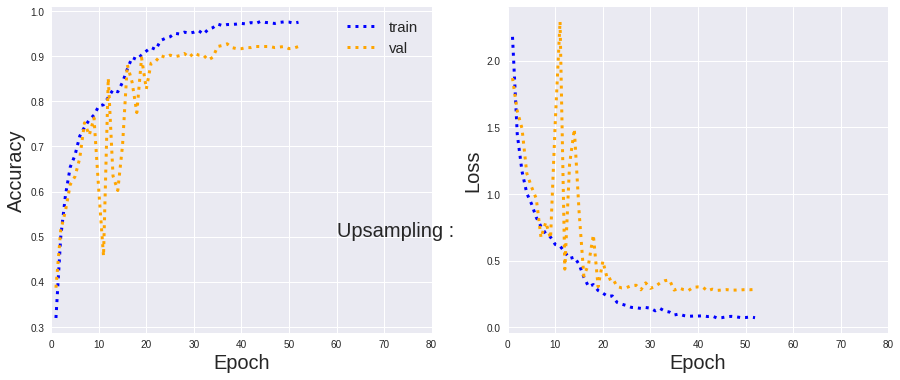

In [76]:
# plot learning curves with model2 and upsampling
plot_results_1([model_info_up],['Upsampling'])

F1 : 0.92
Accuracy : 0.92


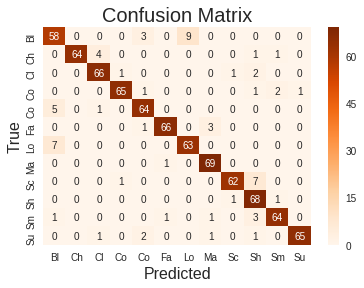

In [77]:
print('F1 : {}'.format(round(f1_up,2)))
print('Accuracy : {}'.format(round(acc_up,2)))
plot_confusion(test_up, pred_up, abbreviation)

In [79]:
from sklearn.metrics import classification_report
print(classification_report(test_up, pred_up, target_names=abbreviation))

              precision    recall  f1-score   support

          Bl       0.82      0.83      0.82        70
          Ch       1.00      0.91      0.96        70
          Cl       0.92      0.94      0.93        70
          Co       0.97      0.93      0.95        70
          Co       0.90      0.91      0.91        70
          Fa       0.97      0.94      0.96        70
          Lo       0.88      0.90      0.89        70
          Ma       0.93      0.99      0.96        70
          Sc       0.97      0.89      0.93        70
          Sh       0.82      0.97      0.89        70
          Sm       0.94      0.91      0.93        70
          Su       0.98      0.93      0.96        70

   micro avg       0.92      0.92      0.92       840
   macro avg       0.92      0.92      0.92       840
weighted avg       0.92      0.92      0.92       840



The performance was almost the same overall. But, there was a huge improvement in the model's ability to classify Black Grass while some other classes saw a slight decrease and precision and recall. More time could be spent tuning the hyper parameters to achive even better results.

## Another Approach - Image Segmentation

It may be beneficial to block the pixels in the images that don't show plants (e.g., soil or pebbles) to allow the CNN models to only focus on plant features when training. 

I used the openCV library in Python to produce image masks based on the colors of pixels, and then made segmented images using those masks. But this process is very complicated, because the quality of the image segmentations depends on the sizes of the images, the morphology of the plant seedlings, and it is extremely sensitive to the range of colors included in the mask filter. 

As a result, I found that some classes of seedlings saw improvements with image segmentation while others (particularly those with long, thin morphologies) had much higher classification errors after applying image segmentation. Ultimately, this approach is one that must be used with extreme caution and it will take more work to refine it to the point where it improves upon the results seen without image segmentation.

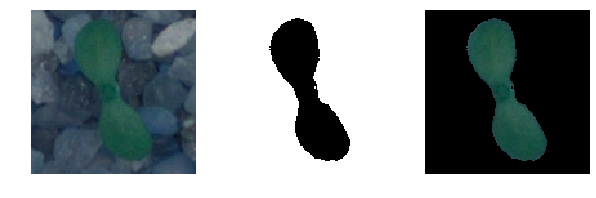

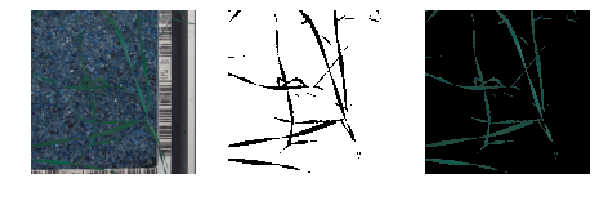

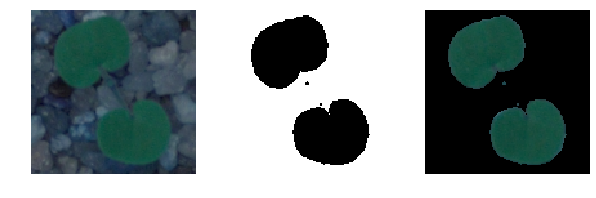

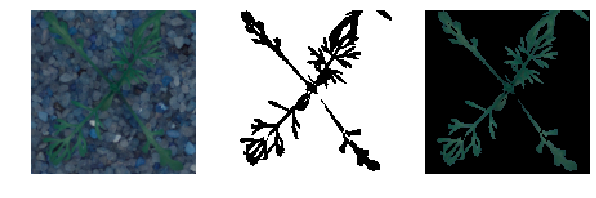

In [87]:
for i in range(118,122):
    img, image_mask, image_segmented = make_segmented_images(df.loc[i,'file'], (128,128))

    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    axs[0].imshow(img.astype(np.uint8))
    axs[1].imshow(image_mask.astype(np.uint8))
    axs[2].imshow(image_segmented.astype(np.uint8))
    axs[0].axis('off'); axs[1].axis('off'); axs[2].axis('off')

In [88]:
tensors = np.zeros((len(df.file), 128, 128, 3), dtype='float32')
for i, filepath in enumerate(df.file):
    _, _, img = make_segmented_images(filepath, (128, 128))
    tensors[i] = np.expand_dims(img, axis=0).astype('float32')/255
    y = np_utils.to_categorical(np.array(df.label.values), 12)
    
X_train, y_train, X_valid, y_valid, X_test, y_test = train_val_test(tensors, y)

In [90]:
model_info, test, pred, f1, acc  = run_model(model = model2, 
                                                    X_train = X_train, 
                                                    y_train = y_train,
                                                    X_valid = X_valid, 
                                                    y_valid = y_valid, 
                                                    verbose = 1,
                                                    X_test = X_test, 
                                                    y_test = y_test, 
                                                    epochs = 200,
                                                    batch_size = 10,
                                                    reduce = reduce_choice[2],
                                                    optimizer = Adam(0.005))


Train on 3800 samples, validate on 475 samples
Epoch 1/200
3800/3800 [==============================] - 43s 11ms/step - loss: 2.2477 - acc: 0.3437 - val_loss: 2.0517 - val_acc: 0.4442
Epoch 2/200
3800/3800 [==============================] - 39s 10ms/step - loss: 1.5135 - acc: 0.5000 - val_loss: 1.1254 - val_acc: 0.6379
Epoch 3/200
3800/3800 [==============================] - 39s 10ms/step - loss: 1.2664 - acc: 0.5863 - val_loss: 1.4627 - val_acc: 0.5263
Epoch 4/200
3800/3800 [==============================] - 39s 10ms/step - loss: 1.1723 - acc: 0.6195 - val_loss: 1.2397 - val_acc: 0.6379
Epoch 5/200
3800/3800 [==============================] - 39s 10ms/step - loss: 1.0865 - acc: 0.6350 - val_loss: 1.1139 - val_acc: 0.6337

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 6/200
3800/3800 [==============================] - 39s 10ms/step - loss: 0.9016 - acc: 0.6942 - val_loss: 0.6907 - val_acc: 0.7621
Epoch 7/200
3800/3800 [===========================

In [ ]:
print('F1 : {}'.format(round(f1,2)))
print('Accuracy : {}'.format(round(acc,2)))
plot_confusion(test, pred, abbreviation)

F1 : 0.78
Accuracy : 0.83


<img src='./img/result.png'>

It is not bad, but it requires either higher resolution images or much more careful tuning of the segmentation parameters.